<a href="https://colab.research.google.com/github/NadaNabil07/svm_from_scratch/blob/main/svm_from_scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [111]:
import numpy as np
import cvxopt
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from scipy import stats
import matplotlib.pyplot as plt


In [112]:
def linear(x, z):
    return np.dot(x, z.T)


def polynomial(p=3, coef0=1):
    def f(x, z):
        return (coef0 + np.dot(x, z.T)) ** p
    return f


def rbf(gamma=0.1):
    def f(x, z):
        return np.exp(-np.linalg.norm(x - z, axis=1) ** 2 / (2 * (gamma ** 2)))
    return f


class SVM:
    def __init__(self, kernel=rbf, C=10):
        self.kernel = kernel
        self.C = C

    def fit(self, X, y):
        self.y = y
        self.X = X
        m, n = X.shape

        # Calculate Kernel
        self.K = np.zeros((m, m))
        for i in range(m):
            self.K[i, :] = self.kernel(X[i, np.newaxis], self.X)

        # Solve with cvxopt final QP needs to be reformulated
        P = cvxopt.matrix(np.outer(y, y) * self.K)
        q = cvxopt.matrix(-np.ones((m, 1)))
        G = cvxopt.matrix(np.vstack((np.eye(m) * -1, np.eye(m))))
        h = cvxopt.matrix(np.hstack((np.zeros(m), np.ones(m) * self.C)))
        A = cvxopt.matrix(y, (1, m), "d")
        b = cvxopt.matrix(np.zeros(1))
        cvxopt.solvers.options["show_progress"] = False
        sol = cvxopt.solvers.qp(P, q, G, h, A, b)
        self.alphas = np.array(sol["x"])

    def predict(self, X):
        y_predict = np.zeros((X.shape[0]))
        sv = self.get_parameters(self.alphas)

        for i in range(X.shape[0]):
            y_predict[i] = np.sum(
                self.alphas[sv]
                * self.y[sv, np.newaxis]
                * self.kernel(X[i], self.X[sv])[:, np.newaxis]
            )

        return np.sign(y_predict + self.b)

    def get_parameters(self, alphas):
        threshold = 1e-5

        sv = ((alphas > threshold) * (alphas < self.C)).flatten()
        self.w = np.dot(self.X[sv].T, alphas[sv] * self.y[sv, np.newaxis])
        self.b = np.mean(
            self.y[sv, np.newaxis]
            - self.alphas[sv] * self.y[sv, np.newaxis] * self.K[sv, sv][:, np.newaxis]
        )
        return sv

In [113]:
#One_vs_ALL  for multiclassification
class MultiClassSVM:
    def __init__(self, kernel=rbf, C=10):
        self.C = C
        self.kernel = kernel
        self.models = []

    def fit(self, X, y):
        self.classes = np.unique(y)
        for c in self.classes:
            # Binary classification problem, class 'c' against other classes
            binary_y = np.where(y == c, 1, -1)
            model = SVM(self.kernel, self.C)
            model.fit(X, binary_y)
            self.models.append(model)

    def predict(self, X):
        # Predict using all binary classifiers and vote for the final output
        predictions = np.zeros((len(self.models), X.shape[0]))
        for i, model in enumerate(self.models):
            predictions[i] = model.predict(X)
        return self.classes[np.argmax(predictions, axis=0)]

In [114]:
from matplotlib.colors import hsv_to_rgb, ListedColormap

def plot_decision_boundary(X, y, model, title):
    markers = ['o', 's', '^', 'D', 'v', '>', 'h', 'p', 'X', '<']

    # Create a custom colormap for the decision boundaries
    unique_classes = np.unique(y)
    colors = [hsv_to_rgb((i / len(unique_classes), 1, 1)) for i in range(len(unique_classes))]


    h = .02
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])

    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, cmap='tab10', alpha=0.8)

    for i in range(len(unique_classes)):
        class_idx = unique_classes[i]
        plt.scatter(X[y == class_idx, 0], X[y == class_idx, 1], c=colors[i], marker=markers[i % len(markers)], s=20, edgecolors='k')

    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.title(title)
    plt.show()

In [115]:
#test the class ...
# Load the data
data = np.loadtxt('Spiral.txt', skiprows=7)
X = data[:, :-1]
y = data[:, -1]
y[y == 2] = -1


In [116]:
# data preprocessing
# Remove outliers
Q1 = np.percentile(X, 25, axis=0)
Q3 = np.percentile(X, 75, axis=0)
IQR = Q3 - Q1
X = X[~((X < (Q1 - 1.5 * IQR)) | (X > (Q3 + 1.5 * IQR))).any(axis=1)]
y = y[~((X < (Q1 - 1.5 * IQR)) | (X > (Q3 + 1.5 * IQR))).any(axis=1)]

# Shuffle the data
X, y = shuffle(X, y, random_state=1)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

# Normalize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)



Kernel: linear, C: 0.1, Accuracy: 0.3492063492063492


<ipython-input-114-ca94c894e74e>:22: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(X[y == class_idx, 0], X[y == class_idx, 1], c=colors[i], marker=markers[i % len(markers)], s=20, edgecolors='k')


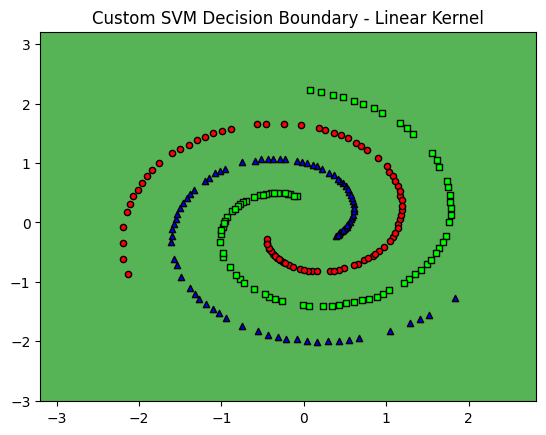

In [117]:
#linear
C=0.1
svm = SVM(kernel=linear, C=C)
y_train_c = np.where(y_train == 1, 1, -1)  # Assuming binary classification with classes -1 and 1
svm.fit(X_train, y_train_c)

# Predict
y_pred = svm.predict(X_test)

# Calculate accuracy
accuracy = sum(y_test == y_pred) / y_test.shape[0]
print(f"Kernel: linear, C: {C}, Accuracy: {accuracy}")

# Plot the decision boundary
plot_decision_boundary(X_train, y_train, svm, "Custom SVM Decision Boundary - Linear Kernel")


Kernel: polynomial, C: 0.1, Accuracy: 0.5238095238095238


<ipython-input-114-ca94c894e74e>:22: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(X[y == class_idx, 0], X[y == class_idx, 1], c=colors[i], marker=markers[i % len(markers)], s=20, edgecolors='k')


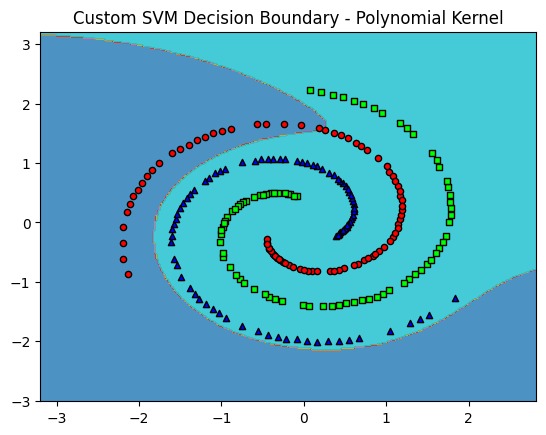

In [118]:
#polynomial
svm = SVM(kernel=polynomial(p=5, coef0=2), C=0.1)
y_train_c = np.where(y_train == 1, 1, -1)  # Assuming binary classification with classes -1 and 1
svm.fit(X_train, y_train_c)

# Predict
y_pred = svm.predict(X_test)

# Calculate accuracy
accuracy = sum(y_test == y_pred) / y_test.shape[0]
print(f"Kernel: polynomial, C: {C}, Accuracy: {accuracy}")

# Plot the decision boundary
plot_decision_boundary(X_train, y_train, svm, "Custom SVM Decision Boundary - Polynomial Kernel")


Kernel: rbf, C: 0.1, Accuracy: 0.5714285714285714


<ipython-input-114-ca94c894e74e>:22: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(X[y == class_idx, 0], X[y == class_idx, 1], c=colors[i], marker=markers[i % len(markers)], s=20, edgecolors='k')


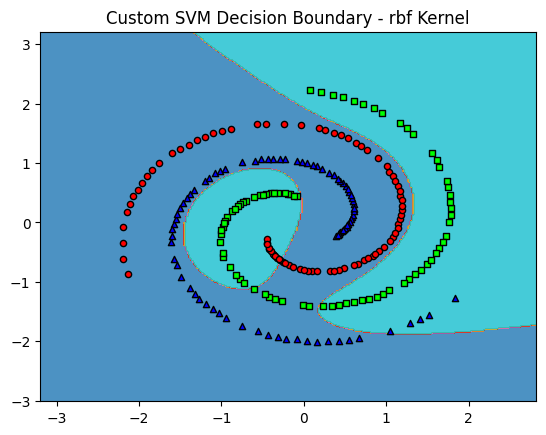

In [119]:
# create a SVM with a rbf kernel with a specific gamma like this:
svm = SVM(kernel=rbf(gamma=1), C=1)
y_train_c = np.where(y_train == 1, 1, -1)  # Assuming binary classification with classes -1 and 1
svm.fit(X_train, y_train_c)

# Predict
y_pred = svm.predict(X_test)

# Calculate accuracy
accuracy = sum(y_test == y_pred) / y_test.shape[0]
print(f"Kernel: rbf, C: {C}, Accuracy: {accuracy}")

# Plot the decision boundary
plot_decision_boundary(X_train, y_train, svm, "Custom SVM Decision Boundary - rbf Kernel")


In [120]:
# comapre svm and svc
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# Set the kernel to 'rbf', C to 0.1 and gamma to 0.1
kernel_svc = 'rbf'
C = 0.1
gamma = 0.1

# Train the SVC model
svc = SVC(kernel=kernel_svc, C=C, gamma=gamma)
svc.fit(X_train, y_train)

# Predict
y_pred_svc = svc.predict(X_test)

# Calculate accuracy
accuracy_svc = accuracy_score(y_test, y_pred_svc)
print(f"SVC - Kernel: {kernel_svc}, C: {C}, Gamma: {gamma}, Accuracy: {accuracy_svc}")

# Train the custom SVM model
kernel_svm = rbf(gamma=0.1)
svm = SVM(kernel=kernel_svm, C=C)
y_train_c = np.where(y_train == 1, 1, -1)  # Assuming binary classification with classes -1 and 1
svm.fit(X_train, y_train_c)

# Predict
y_pred_svm = svm.predict(X_test)

# Calculate accuracy
accuracy_svm = sum(y_test == y_pred_svm) / y_test.shape[0]
print(f"SVM - Kernel: rbf, C: {C},gamma:{gamma} , Accuracy: {accuracy_svm}")

SVC - Kernel: rbf, C: 0.1, Gamma: 0.1, Accuracy: 0.30158730158730157
SVM - Kernel: rbf, C: 0.1,gamma:0.1 , Accuracy: 0.42857142857142855


In [121]:
# comapre the accuercy of the  SVC with this SVM with differnt kernels
# Set the parameters for comparison
kernels = ['linear', 'poly', 'rbf']
C = 0.1
gamma = 0.1
degree = 3

for kernel in kernels:
    if kernel == 'poly':
        # Train the SVC model with polynomial kernel
        svc = SVC(kernel=kernel, C=C, gamma=gamma, degree=degree)
    else:
        # Train the SVC model with linear or rbf kernel
        svc = SVC(kernel=kernel, C=C, gamma=gamma)

    svc.fit(X_train, y_train)
    y_pred_svc = svc.predict(X_test)
    accuracy_svc = accuracy_score(y_test, y_pred_svc)
    print(f"SVC - Kernel: {kernel}, C: {C}, Gamma: {gamma}, Degree: {degree}, Accuracy: {accuracy_svc}")

    # Train the custom SVM model
    if kernel == 'poly':
        kernel_svm = polynomial(p=degree)
    elif kernel == 'rbf':
        kernel_svm = rbf(gamma=gamma)
    else:
        kernel_svm = linear

    svm = SVM(kernel=kernel_svm, C=C)
    y_train_c = np.where(y_train == 1, 1, -1)
    svm.fit(X_train, y_train_c)
    y_pred_svm = svm.predict(X_test)
    accuracy_svm = accuracy_score(y_test, y_pred_svm)
    print(f"SVM - Kernel: {kernel}, C: {C}, Gamma: {gamma}, Degree: {degree}, Accuracy: {accuracy_svm}")


SVC - Kernel: linear, C: 0.1, Gamma: 0.1, Degree: 3, Accuracy: 0.2857142857142857
SVM - Kernel: linear, C: 0.1, Gamma: 0.1, Degree: 3, Accuracy: 0.3492063492063492
SVC - Kernel: poly, C: 0.1, Gamma: 0.1, Degree: 3, Accuracy: 0.30158730158730157
SVM - Kernel: poly, C: 0.1, Gamma: 0.1, Degree: 3, Accuracy: 0.5238095238095238
SVC - Kernel: rbf, C: 0.1, Gamma: 0.1, Degree: 3, Accuracy: 0.30158730158730157
SVM - Kernel: rbf, C: 0.1, Gamma: 0.1, Degree: 3, Accuracy: 0.42857142857142855


Kernel: rbf, C: 0.1, Accuracy: 1.0


<ipython-input-114-ca94c894e74e>:22: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(X[y == class_idx, 0], X[y == class_idx, 1], c=colors[i], marker=markers[i % len(markers)], s=20, edgecolors='k')


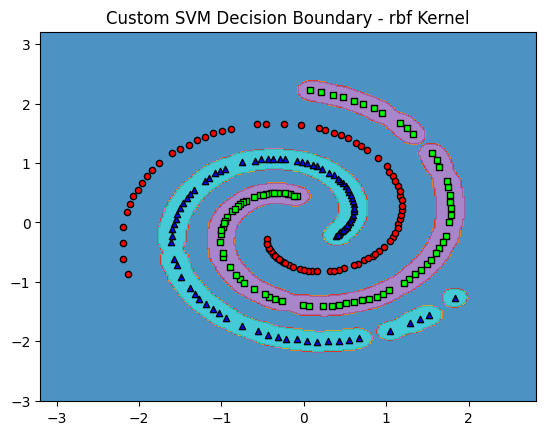

In [125]:
# create a MultiClassSVM with a rbf kernel with a specific gamma like this:
svm = MultiClassSVM(kernel=rbf(gamma=0.1), C=1)
svm.fit(X_train, y_train)

# Predict
y_pred = svm.predict(X_test)

# Calculate accuracy
accuracy = sum(y_test == y_pred) / y_test.shape[0]
print(f"Kernel: rbf, C: {C}, Accuracy: {accuracy}")


# Plot the decision boundary
plot_decision_boundary(X_train, y_train, svm, "Custom SVM Decision Boundary - rbf Kernel")

# Plot the decision boundary
# Note: The decision boundary plot might not work directly because it's designed for binary classification
# You might need to modify the function to support multi-class classification
# plot_decision_boundary(X_train, y_train, svm, "Custom SVM Decision Boundary - rbf Kernel")